In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from replay_buffer import ReplayBuffer
from sinewaves import (
    SINX, COSX, 
    Environment, Observation, arrange)
from investor_model_cnn import new_actor, new_critic

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
import tensorflow.keras as tk
import tensorflow.keras.layers as tkl

### Convenient Helpers

#### Plot an Actor's Behaviour
Plot the portfolio holdings of an actor against the asset values in time

In [5]:
def plot_behaviour(actor, length, env=None):
    DEFAULT_FEE=2.5e-3
    env = env or Environment(7, [4e5, 3e5, 3e5], fee=DEFAULT_FEE)
    from copy import deepcopy
    env = deepcopy(env)
    wealth = []
    sin = []
    cos = []
    psin = []
    pcos = []
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, actor.n_portfolio)
    for i in range(length):
        action = actor([mh, pw]).numpy()[0]
        obs = env.step(action)
        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
        pw = pw.reshape(1, actor.n_portfolio)
        wealth.append(env.wealth()/1e8)
        sin.append(obs.s[0][-1][0])
        cos.append(obs.s[0][-1][1])
        psin.append(action[1]/100)
        pcos.append(action[2]/100)

    plt.plot(sin)
    plt.plot(cos)
    plt.plot(psin)
    plt.plot(pcos)
    plt.plot(wealth);

#### Portfolio along the episode

In [6]:
def actions_from_episode(actor, env, length):
    from copy import deepcopy
    env = deepcopy(env)
    actions = []
    mh, pw = env.state()
    mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, actor.n_portfolio)
    for i in range(length):
        action = actor([mh, pw]).numpy()[0]
        actions.append(action)
        obs = env.step(action)
        mh, pw = env.state()
        mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
        pw = pw.reshape(1, actor.n_portfolio)
    return np.array(actions).T

#### Validate an Actor
Compute the actor's success in the market

In [7]:
def validate(actor, env, length, start_at=0):
    from copy import deepcopy
    env = deepcopy(env)
    env.t = start_at
    w0 = env.wealth()
    mh, pw = env.state()
    mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, actor.n_portfolio)
    for i in range(length):
        action = actor([mh, pw]).numpy()[0]
        obs = env.step(action)
        mh, pw = env.state()
        mh = 1000*mh.reshape(1, actor.n_history, actor.n_market, 1)
        pw = pw.reshape(1, actor.n_portfolio)
    return np.log(env.wealth() / w0), env.total_fees

#### Discounted N-Step Returns

In [8]:
def dnsr(actor, env, n_steps):
    """Discounted n-step returns"""
    from copy import deepcopy
    env = deepcopy(env)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    GAMMA_N=np.array([GAMMA**i for i in range(n_steps) ])
    rewards = []
    for i in range(N_STEPS):
        action = actor([mh, pw])
        obs = env.step(action.numpy()[0])
        rewards.append(obs.r)

        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, N_H, N_M, 1)
        pw = pw.reshape(1, N_P)

    return np.matmul(GAMMA_N, np.array(rewards))

#### N-Step Targets

In [9]:
def n_step_target(pa, tc, ta, env):
    """
    Compute N-step targets:
    pa: Primary actor
    tc: Target critic
    ta: Target actor
    """
    return dnsr(pa, env, n_steps) + GAMMA**(n_steps+1) * tc([mh, pw, ta([mh, pw])])

#### Longterm Return-for-Action
Calculates the return that a rebalance-and-hold strategy would yield for a given duration. This is uses in training to avoid the fee frustration. 
Typically, the fee penalty makes an actor learn to hold and not trade at all. That's because the immediate one-day gain is typically lower than the associated fee, making any re-balance less attractive than just keeping the portfolio as is.

In [10]:
def longterm_exp_return(env, actor, action, duration):
    """
    This function takes 'duration' steps in a copy of the environment using 
    the same action. Use it to compare the long term promise of a new set of 
    portfolio weights with the existing portfolio weights. And only change 
    the portfolio if the new weights have a more promising outlook. Note that 
    this little 'cheat' makes the algorithm model-based!
    """
    from copy import deepcopy
    env = deepcopy(env)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, actor.n_history, actor.n_market, 1)
    pw = pw.reshape(1, N_P)

    wb = env.wealth()
    for _ in range(16):
        obs = env.step(action)
    return np.log(env.wealth() / wb)


---
### Pre-Training the actor with heuristics

#### The *expert* - a simple heuristic
Note that this only works because we know that the market has long, smooth periods of ups and downs.

In [11]:
def heuristic_hold(x):
    """
    hold the asset with the highest total return during the most recent history period
    """
    batch_size = len(x)
    x1 = np.squeeze(x)
    sums = np.sum(x1, axis=1)
    sums_and_cash = np.hstack([np.zeros([batch_size, 1], dtype=np.float32), sums])
    max_sums = np.max(sums_and_cash, axis=-1)
    labels = ((sums_and_cash - max_sums.reshape([batch_size, 1])) == 0).astype(np.float32)
    return labels

In [12]:
n_batch = 256
n_history = 7
n_market = 2
n_portfolio = 3
n_filters = 4

In [13]:
eval_mh = 10*(np.random.random([100, n_history, n_market, 1]).astype(np.float32)-.5)
eval_pw = np.random.random([100, n_portfolio]).astype(np.float32)

In [14]:
def generator():
    while(True):
        train_mh = 10* (np.random.random([n_batch, n_history, n_market, 1]).astype(np.float32)-.5)
        train_pw = np.random.random([n_batch, n_portfolio]).astype(np.float32)
        x=[train_mh, train_pw]
        y=heuristic_hold(train_mh)
        yield((x,y))

In [15]:
primary_actor = new_actor(n_market, n_history, n_filters, n_portfolio)
adam = tf.optimizers.Adam(learning_rate=1e-2)
primary_actor.compile(adam, 'mse')

In [16]:
validation_data=([eval_mh, eval_pw], heuristic_hold(eval_mh))
history = primary_actor.fit_generator(epochs = 20, generator=generator(),
                                   steps_per_epoch=10,
                                    verbose=0, 
                                   validation_data=validation_data)

In [17]:
y=heuristic_hold(eval_mh)
[(primary_actor([eval_mh, eval_pw])[i].numpy(), y[i]) for i in range(5)]

[(array([1.0000000e+00, 9.0412433e-09, 1.5988119e-12], dtype=float32),
  array([1., 0., 0.], dtype=float32)),
 (array([9.7345799e-01, 3.1629361e-07, 2.6541611e-02], dtype=float32),
  array([1., 0., 0.], dtype=float32)),
 (array([2.7822189e-11, 1.0000000e+00, 1.7168164e-12], dtype=float32),
  array([0., 1., 0.], dtype=float32)),
 (array([3.6426038e-05, 9.9992418e-01, 3.9331884e-05], dtype=float32),
  array([0., 1., 0.], dtype=float32)),
 (array([3.2930052e-07, 9.9995351e-01, 4.6166282e-05], dtype=float32),
  array([0., 1., 0.], dtype=float32))]

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

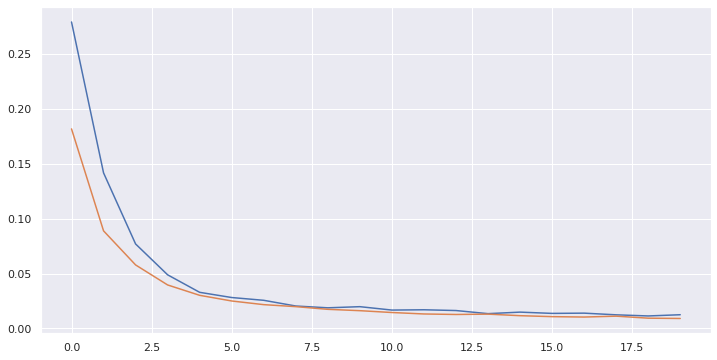

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);

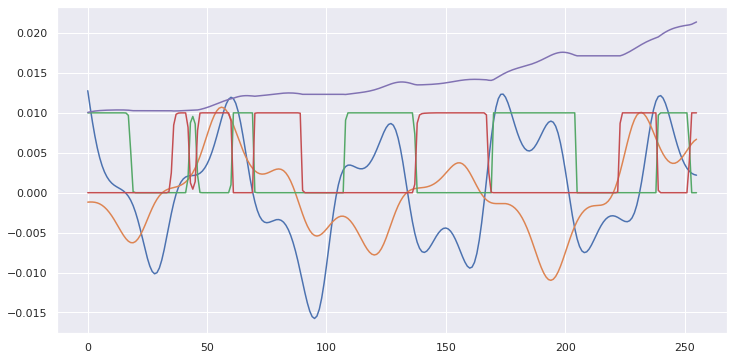

In [20]:
plot_behaviour(primary_actor, length=256)

We can see that the heuristic tought our network to hold on to the best-performing stock at any point in time

In [21]:
N_M = 2
N_P = 3
N_H = 7
N_LTR = 4
FEE = 2.5e-3
N_EPISODES = 500
N_LOG_ACTIONS = 10
N_STEPS = 256
N_SPRINT = 4
N_UPDATE_CRITIC = 16
N_UPDATE_ACTOR = 16
RETURN_SCALE=100
TARGET_SCALE=10
N_FILTERS = 4
NOISE_LEVEL = 0.1
N_BATCH = 256
GAMMA = 0.999
TAU = 0.1

## Studying Q values

In [22]:
primary_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
small_weights = [w/1e6 for w in primary_critic.get_weights()]
primary_critic.set_weights(small_weights)
pc_loss = tf.keras.losses.mean_squared_error
pc_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
primary_critic.compile(loss = pc_loss, optimizer=pc_optimizer)

### Bellmann update in isolation using the expert-trained actor

In [23]:
env = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
for i in range(1024):
    
    # observe
    mh, pw = env.state()
    mh = RETURN_SCALE * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    
    # take action
    a = primary_actor([mh, pw])
    action = a.numpy()[0]
    observation = env.step(action)
    r = observation.r
    
    # next state
    mh1, pw1 = env.state()
    mh1 = RETURN_SCALE * mh1.reshape(1, N_H, N_M, 1)
    pw1 = pw1.reshape(1, N_P)
    
    # Q-target
    Q = primary_critic([mh1, pw1, primary_actor([mh1, pw1])])
    y = TARGET_SCALE * r + GAMMA * Q

    for _ in range(2):
        primary_critic.train_on_batch(x=[mh, pw, a], y=y)

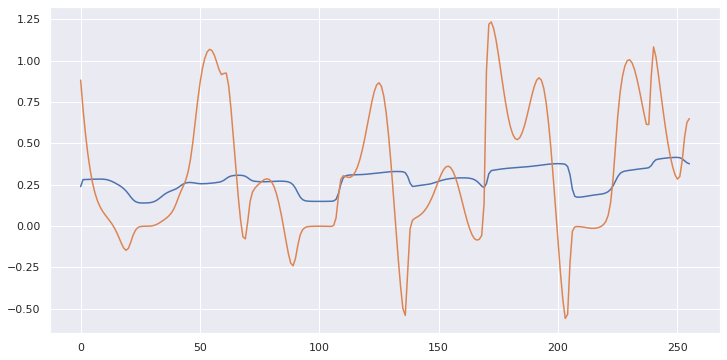

In [24]:
qvals=[]
rewards=[]
env = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
for i in range(256):
    mh, pw = env.state()
    mh = RETURN_SCALE * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    action = primary_actor([mh, pw]).numpy()[0]
    observation = env.step(action)
    Q = primary_critic([mh, pw, primary_actor([mh, pw])])
    qvals.append(Q.numpy()[0])
    rewards.append(100*observation.r)
plt.plot(qvals)
plt.plot(rewards);

This is a disappointing result. the Q-function appears to be generally increasing. And its sharp ups and downs don't really look like they know what the total return of the remaining steps is - and that is what we expect the Q-function to represent!

## The *true* Q-function
We're looking for the function that tells us the maximum return on the *perfect trajectory*. And we can actually find it quickly with the help of the optimal actor. We just collect the returns on this actor's path and calculate the Q-function from them. Note that things are so easy only because 

1. we trained the optimal actor with labels generated by a heuristic expert in a supervised fashion, and
2.  we trade on a fully deterministic market, still.

#### Prepare supervised learning 

In [260]:
gamma=.999

In [344]:
N_T = 256
mhs = []
pws = []
actions = []
rewards = []
env = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
for i in range(N_T):
    mh, pw = env.state()
    mhs.append(mh)
    pws.append(pw)
    mh = RETURN_SCALE * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    a = primary_actor([mh, pw])
    action = a.numpy()[0]
    actions.append(action)
    rewards.append(env.step(action).r)

In [345]:
def qfun_from_rewards(rewards, gamma):
    q = 0
    tqvals = []
    for t in range(len(rewards)-1, -1, -1):
        q = rewards[t] + gamma * q
        tqvals.append(q)
    tqvals = np.array(tqvals[::-1])
    return tqvals

In [346]:
tqvals = qfun_from_rewards(rewards, gamma)
tqvals[-1]

0.0064975665882229805

#### Quick-checking the Bellmann equation along the optimum trajectory

In [347]:
print([tqvals[t] == (rewards[t] + gamma * tqvals[t+1]) for t in range(min(20, len(rewards)-1))])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


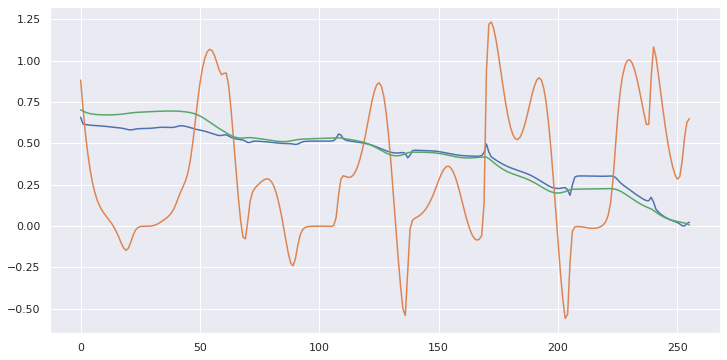

In [348]:
plt.plot(qvals)
plt.plot(np.array(rewards)*RETURN_SCALE)
plt.plot(tqvals);

#### Supervised training with the *true* Q-function

In [349]:
mhs_ = np.expand_dims(mhs, axis=-1)
x = [mhs_, np.array(pws), np.array(actions)]
y = np.reshape(tqvals, [256, 1])

In [350]:
history = primary_critic.fit(x=x, y=y, epochs=3000, verbose=False)

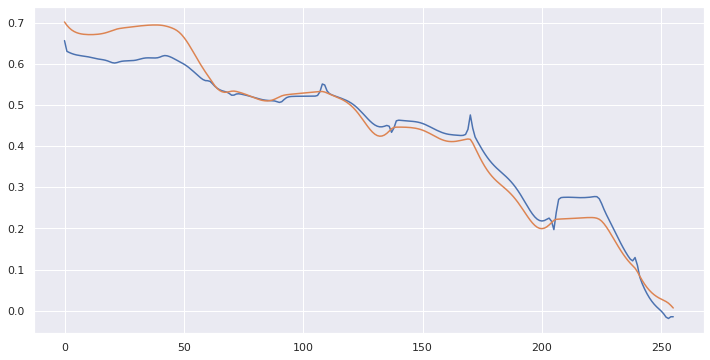

In [351]:
qvals=[]
rewards=[]
env = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
for i in range(256):
    mh, pw = env.state()
    mh = RETURN_SCALE * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    action = primary_actor([mh, pw]).numpy()[0]
    observation = env.step(action)
    Q = primary_critic([mh, pw, primary_actor([mh, pw])])
    qvals.append(Q.numpy()[0])
    rewards.append(100*observation.r)
plt.plot(qvals)
plt.plot(tqvals);

We can see that the chosen NN architecture for the Q-function is able to learn when tought by an expert (that's us) in a supervised setting. That does not mean it will find this solution with the bellmann updates alone - at least not efficiently. 

#### Playing with the Bellmann problem
Let's convince ourself that the Bellmann update does indeed converge to the expected maximum return on a fixed trajectory.

In [510]:
N_T = 32

In [519]:
rewards=2*np.random.random(N_T)-.8

In [512]:
qfun = qfun_from_rewards(rewards, gamma=.999)

In [520]:
X_SCALE=1.
x = np.array( [[t, np.random.random()] for t in range(N_T)])
x_=x/X_SCALE #[:-1]

In [545]:
activation = tf.keras.activations.elu
#activation = 'relu'
inputs = tk.Input(shape=[2], dtype=tf.float32)
y = inputs

for u in [16, 32, 64, 32, 16, 8]:
    y = tkl.Dense(units=u, activation=activation)(y)


y = tkl.Dense(units=1, activation=None)(y)

#coeffs = tf.Variable([.1, .1, .1, .1, .1])
#outputs = y * (coeffs[0] + y * (coeffs[1] + y * (coeffs[2] + y * ( coeffs[3] + coeffs[4] * y))))
outputs = y

In [546]:
loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

[[-0.09240235 -0.19057144 -0.11057674 -0.20145582 -0.28254172 -0.31958976
  -0.3210313  -0.400073   -0.4397123  -0.4680135  -0.4930682  -0.53356624
  -0.56268865 -0.5861129  -0.6049571  -0.6429458  -0.66792023 -0.70236534
  -0.7240661  -0.7541903  -0.77195734 -0.7979583  -0.81601596 -0.838449
  -0.85838497 -0.8727163  -0.8902033  -0.9034132  -0.91702497 -0.92986345
  -0.9411715  -0.95198953]]


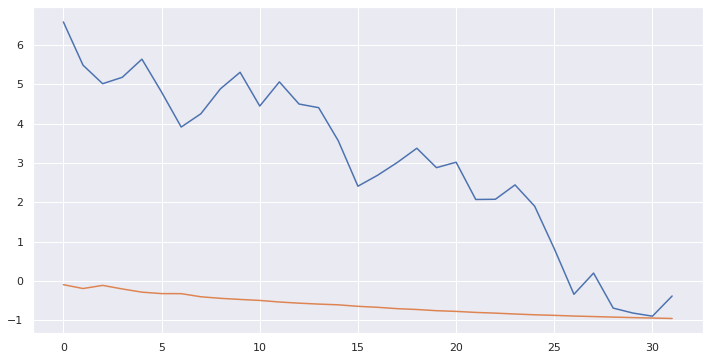

In [547]:
Q = tk.Model(inputs, outputs)
small_weights = [w/1.0 for w in Q.get_weights()]
Q.set_weights(small_weights)
Q.compile(optimizer, loss)
q_est = Q(x_).numpy()
plt.plot(qfun)
plt.plot(q_est.T[0])
print(q_est.T)

loss: [0.02446545660495758]
loss: [0.03398001194000244]
loss: [0.03633260354399681]
loss: [0.03432728350162506]
loss: [0.01558180432766676]
loss: [0.042090266942977905]
loss: [0.015833532437682152]
loss: [0.027540281414985657]
loss: [0.034916989505290985]
loss: [0.05940462648868561]
loss: [0.05056758224964142]


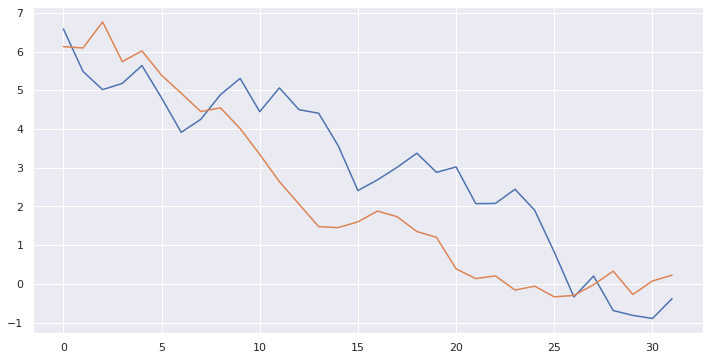

In [552]:
for i in range(1001):
    y_t = [(rewards[t] + gamma * Q(np.expand_dims(x_[t+1], axis=0)).numpy()[0][0]) for t in range(N_T-1)]
    y_t.append(0.)
    history=Q.fit(x=x_, y=y_t, epochs=1, verbose=False)
    if i % 100 == 0:
        print("loss: %s" % history.history['loss'])

q_est = Q(x_).numpy()
plt.plot(qfun)
plt.plot(q_est.T[0]);

In [111]:
coeffs = tf.Variable([.1, .1, .1, .1, .1])

In [ ]:
coeffs[0] * y

#### A better critic update?

# DDPG

(0.8501428096785257, 108209.64)

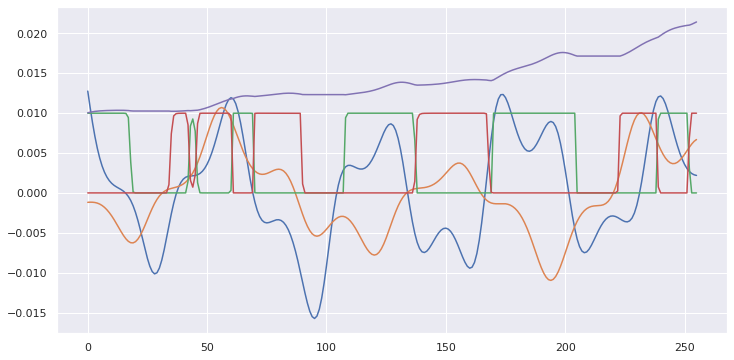

In [22]:
# We're now using a pre-trained actor
#primary_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_actor =  new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_actor.set_weights(primary_actor.get_weights())

primary_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
small_weights = [w/10 for w in primary_critic.get_weights()]
primary_critic.set_weights(small_weights)
pc_loss = tf.keras.losses.mean_squared_error
pc_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
primary_critic.compile(loss = pc_loss, optimizer=pc_optimizer)
pa_optimizer = tf.keras.optimizers.SGD(learning_rate=3e-3)

target_critic =  new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
target_critic.set_weights(primary_critic.get_weights())

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

env = Environment(N_H, [4e5, 3e5, 3e5], fee=2.5e-3)
plot_behaviour(primary_actor, env, 256)
validate(target_actor, env, 256)

In [41]:
import shutil
import datetime

logs = '/home/wgiersche/workspace/financials/logs'
shutil.rmtree(logs, ignore_errors=True)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/001/' + current_time + '/train'
test_log_dir = 'logs/001/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
start_from=0
rb = ReplayBuffer(N_BATCH * 2)

In [43]:
prev_action = None
histories = []
gstats = {}
layer_names = ['out', 'out_b', 
               #'hidden2', 'hidden2_b', 'hidden1', 'hidden1_b', 
               'cnn', 'cnn_b']
for episode in range(N_EPISODES):

    for layer in layer_names: 
        gstats[layer]=[]

    env = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
    env.t = np.floor(2000 * np.random.random()).astype(int)
    Return = 0
    history={
        'actions': [],
        'target_optim': [],
        'advances': [],
        'rewards': []
    }
    histories.append(history)
    
    for step in range(N_STEPS // N_SPRINT):

        for sprint in range(N_SPRINT): 
            # Observe market history and current portfolio weights
            mh, pw = env.state()
            mh = RETURN_SCALE * mh.reshape(1, N_H, N_M, 1)
            pw = pw.reshape(1, N_P)

            # Decide for an action, add some noise to support exploration
            action = primary_actor([mh, pw]).numpy()[0]
            action += np.random.random([N_P]) * NOISE_LEVEL
            action /= np.sum(action)

            # Fall back to prev action if it promises more LTR given current state
            if True:
                if prev_action is not None:
                    ltr = longterm_exp_return(env=env, actor=primary_actor, 
                                              action=action, duration=N_LTR)
                    prev_ltr = longterm_exp_return(env=env, actor=primary_actor, 
                                                   action=prev_action, duration=N_LTR)
                    action = action if ltr > prev_ltr else prev_action
                prev_action = action

            history['actions'].append(action)

            # Execute action and store the results        
            observation = env.step(action)
            Return += observation.r
            history['rewards'].append(RETURN_SCALE*observation.r)
            rb.add([observation])
        
        
        
        # Sample a minibatch
        n_batch = min(N_BATCH, rb.cur_size)
        batch = rb.get_batch(n_batch)
        mh, pw, a, r, mh1, pw1 = arrange(batch)
        mh = RETURN_SCALE * mh.reshape(n_batch, N_H, N_M, 1)
        mh1 = RETURN_SCALE * mh1.reshape(n_batch, N_H, N_M, 1)
        
        # Compute Q-targets
        y = TARGET_SCALE * r + GAMMA * target_critic([mh1, pw1, target_actor([mh1, pw1])])
            
        # Update primary critic
        losses = [
            primary_critic.train_on_batch(x=[mh, pw, a], y=y)
            for _ in range(N_UPDATE_CRITIC)
        ]
        history['target_optim'].append(losses[-1] - losses[0])

        
        # Policy gradient update
        q0 = primary_critic([mh, pw, primary_actor([mh, pw])])
        for _ in range(N_UPDATE_ACTOR):
            with tf.GradientTape() as tape:
                actions = primary_actor([mh, pw])
                loss = -tf.reduce_mean(primary_critic([mh, pw, actions]))
            theta = primary_actor.trainable_variables
            gradients = tape.gradient(loss, theta)
            pa_optimizer.apply_gradients(zip(gradients, theta));
        q1 = primary_critic([mh, pw, primary_actor([mh, pw])])
        history['advances'].append(np.mean(q1)-np.mean(q0))
        for i in range(len(layer_names)):
            gstats[layer_names[i]] = {'max': np.max(gradients[i]), 
                                      'min': np.min(gradients[i]), 
                                      'mean': np.mean(gradients[i]),
                                      'std': np.std(gradients[i])}
        
        
        # Update the target network
        weight_pairs = zip(target_actor.get_weights(), primary_actor.get_weights())
        new_actor_weights = [taw * ( 1 - TAU ) + paw * TAU for taw, paw in weight_pairs]
        target_actor.set_weights(new_actor_weights)

        weight_pairs = zip(target_critic.get_weights(), primary_critic.get_weights())
        new_critic_weights = [tcw * ( 1 - TAU ) + pcw * TAU for tcw, pcw in weight_pairs]
        target_critic.set_weights(new_critic_weights)

        
    #if episode % 5 == 0:
    success, _ = validate(env=env, actor=primary_actor, length=256)
    print("Episode: %s, Training: %s, Validate: %s" %(episode, Return, success))

    logstep = episode+start_from
    env1 = Environment(7, [4e5, 3e5, 3e5], fee=FEE)
    with train_summary_writer.as_default():
        tf.summary.scalar('training_return', Return, step=logstep)
        tf.summary.scalar('validation_return', success, step=logstep)
        for layer_name in layer_names:
            tf.summary.scalar('gradient mean %s' % layer_name, 
                              gstats[layer_name]['mean'], step=logstep)
        
        if logstep % N_LOG_ACTIONS == 0:
            _, SINX, COSX = actions_from_episode(target_actor, env1, N_STEPS)
            for i in range(N_STEPS):
                tf.summary.scalar('SINX:%s' % (logstep), SINX[i], step=i)
                tf.summary.scalar('COSX:%s' % (logstep), COSX[i], step=i)
                
start_from += episode + 1

Episode: 0, Training: 0.8076115295589261, Validate: 0.7419543


KeyboardInterrupt: 

In [58]:
print(primary_actor.layers[1])
primary_actor.layers[1](mh)

InvalidArgumentError: input must be 4-dimensional[256,7,2] [Op:Conv2D]

In [55]:
np.shape(batch)

(256,)

In [56]:
mh, pw, a, r, mh1, pw1 = arrange(batch)

array([[[ 0.00277812,  0.00553101],
        [ 0.00272843,  0.00599941],
        [ 0.00276315,  0.00639961],
        ...,
        [ 0.00297663,  0.00686679],
        [ 0.00308134,  0.00687874],
        [ 0.00312293,  0.00671997]],

       [[ 0.00149722, -0.00089787],
        [ 0.00425909, -0.00111881],
        [ 0.00682168, -0.00125988],
        ...,
        [ 0.01067771, -0.00136128],
        [ 0.01178105, -0.00135884],
        [ 0.01231778, -0.00134648]],

       [[-0.00101612, -0.00599851],
        [-0.00153677, -0.00566331],
        [-0.00220906, -0.00512259],
        ...,
        [-0.00405902, -0.00349966],
        [-0.0052218 , -0.00249877],
        [-0.00649717, -0.00144658]],

       ...,

       [[ 0.00472868,  0.00322049],
        [ 0.00410144,  0.00359734],
        [ 0.00358902,  0.00403661],
        ...,
        [ 0.00293087,  0.00502798],
        [ 0.00277812,  0.00553101],
        [ 0.00272843,  0.00599941]],

       [[ 0.00352773, -0.00338614],
        [ 0.00295892, -0.00

In [31]:
gradients

In [ ]:
env = Environment(N_H, [4e5, 3e5, 3e5], fee=2.5e-3)
plot_behaviour(primary_actor, env, 256)
validate(target_actor, env, 256)

In [32]:
print(histories[6]['target_optim'])
#losses

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [33]:
print(histories[9]['rewards'])

[-0.058132968842983246, -0.04300350323319435, -0.03792793722823262, -0.03402232425287366, -0.03126616356894374, -0.029607692267745733, -0.028413927648216486, -0.02857591724023223, -0.0293781328946352, -0.03398045897483826, -0.035319041926413774, -0.03640594892203808, -0.03677146742120385, -0.03594652749598026, -0.03349005011841655, -0.029042174573987722, -0.022392291575670242, -0.013551353476941586, -0.0028006182401441038, 0.01666467869654298, 0.03128754906356335, 0.04537999164313078, 0.05769860465079546, 0.06716059520840645, 0.07300722412765026, 0.07491708267480135, 0.07302734069526196, 0.06787932477891445, 0.06028326693922281, 0.05118599161505699, 0.019022003980353475, 0.01520192832686007, 0.011867393041029572, 0.009084388730116189, 0.005858612130396068, 0.005190217634662986, 0.005060345865786076, 0.005438040825538337, 0.006277974462136626, 0.007515705074183643, 0.009068905492313206, 0.010837402660399675, 0.012685356196016073, 0.014649622607976198, 0.01622432842850685, 0.017339446349

In [77]:
print(histories[9]['advances'])

[0.0, 3.7252903e-09, 0.0, 7.450581e-09, 0.0, 0.0, 3.7252903e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [322]:
fresh_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
fresh_critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
small_weights = [w/10 for w in fresh_critic.get_weights()]
fresh_critic.set_weights(small_weights)

In [127]:
def plot_q(actor, critic, length=256):
    env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
    mh, pw = env.state()
    mh = 1000 * mh.reshape(1, N_H, N_M, 1)
    pw = pw.reshape(1, N_P)
    qvals = []
    for i in range(length):
        action = actor([mh, pw])
        qvals.append(critic([mh, pw, action]).numpy()[0][0])
        env.step(action.numpy()[0])
        mh, pw = env.state()
        mh = 1000 * mh.reshape(1, N_H, N_M, 1)
        pw = pw.reshape(1, N_P)
    plt.plot(qvals)
    return qvals

In [128]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

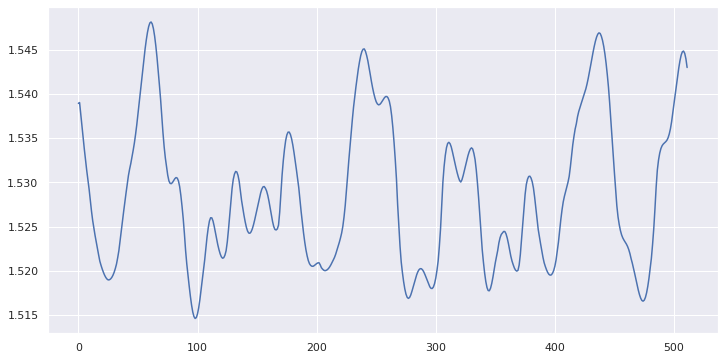

In [130]:
res = plot_q(primary_actor, primary_critic, length=512)

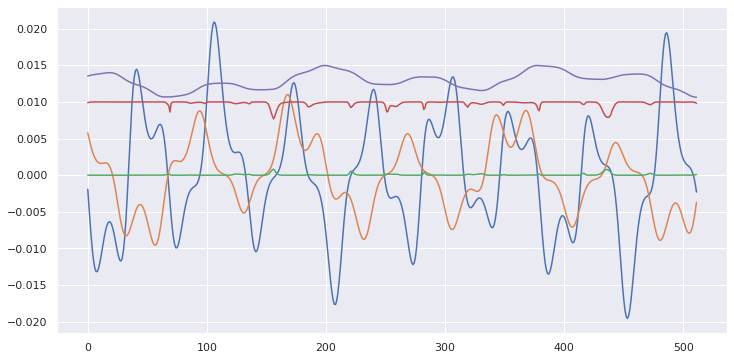

In [131]:
plot_behaviour(target_actor, env, 512)

In [79]:
actions = actions_from_episode(target_actor, env, 16)
actions[0]

array([0.29621524, 0.34873357, 0.3706139 , 0.3591483 , 0.33679965,
       0.3468045 , 0.34860367, 0.32102945, 0.32024685, 0.32668987,
       0.30817088, 0.2900279 , 0.27487367, 0.2635427 , 0.2562897 ,
       0.25044355], dtype=float32)

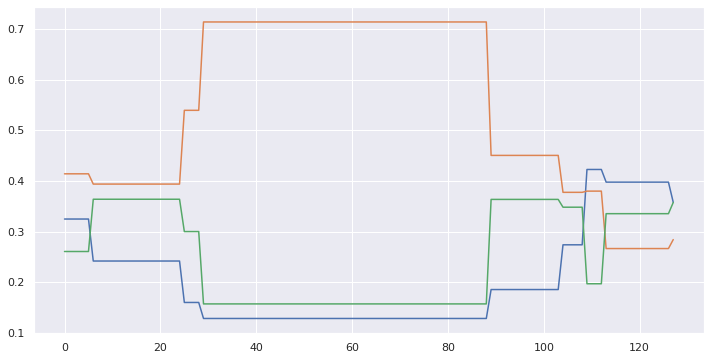

In [53]:
ah = np.array(histories[9]['actions']).T
plt.plot(ah[1]);
plt.plot(ah[2]);
plt.plot(ah[0]);

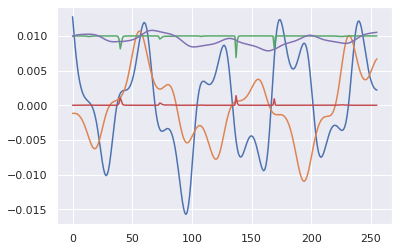

In [105]:
#primary_actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
LENGTH=256
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
plot_behaviour(primary_actor, env, LENGTH)

### Multi-step returns

In [384]:
env = Environment(N_H, [4e5, 3e5, 3e5], fee=1e-2)
actor = new_actor(N_M, N_H, N_FILTERS, n_portfolio=N_P)
critic = new_critic(N_M, N_H, N_FILTERS, n_portfolio=N_P)
loss = tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
critic.compile(loss = loss, optimizer=optimizer)

In [388]:
GAMMA_N=np.array([GAMMA**i for i in range(3) ])
GAMMA_N

array([1.        , 0.9999    , 0.99980001])

In [402]:
n_steps = 3
dnsr(actor, critic, env, n_steps)

-0.004725434919184604

In [417]:
n_step_target(primary_actor, target_critic, target_actor, env)

<tf.Tensor: id=179014517, shape=(1, 1), dtype=float32, numpy=array([[-0.00293337]], dtype=float32)>

In [104]:
# Sample a minibatch
N_BATCH=2
n_batch = min(N_BATCH, rb.cur_size)
batch = rb.get_batch(min(N_BATCH, rb.cur_size))
mh, pw, a, r, mh1, pw1 = arrange(batch)
mh = 1000 * mh.reshape(n_batch, N_H, N_M, 1)
mh1 = 1000 * mh1.reshape(n_batch, N_H, N_M, 1)

# Compute Q-targets
y = r + GAMMA * critic([mh1, pw1, actor([mh1, pw1])])

# Update critic
losses = [
    critic.train_on_batch(x=[mh, pw, a], y=y)
    for _ in range(20)
]

list(zip(np.squeeze(y.numpy()), 
         np.squeeze(
             critic([mh1, pw1, actor([mh1, pw1])]).numpy())))

[(-0.9069708, -1.0828686), (-0.7213703, -0.71334255)]

In [105]:
critic([mh1, pw1, actor([mh1, pw1])])

<tf.Tensor: id=301938, shape=(2, 1), dtype=float32, numpy=
array([[-1.0828686 ],
       [-0.71334255]], dtype=float32)>

In [106]:
losses

[0.0150690535,
 0.004645823,
 0.0013788156,
 0.00037454598,
 9.1800015e-05,
 2.386989e-05,
 6.882161e-06,
 2.269493e-06,
 8.544768e-07,
 3.5576218e-07,
 1.5777981e-07,
 7.2413705e-08,
 3.3807595e-08,
 1.5956605e-08,
 7.514339e-09,
 3.5670702e-09,
 1.6874058e-09,
 7.9710993e-10,
 3.7667647e-10,
 1.7989699e-10]

In [72]:
from copy import deepcopy
# Observe market history and current portfolio weights
mh, pw = env.state()
mh = mh.reshape(1, N_H, N_M, 1)
pw = pw.reshape(1, N_P)
action = primary_actor([mh, pw]).numpy()[0]
samples=[]
for i in range(256):

    # Decide for an action, add some noise to support exploration
    a = action + np.random.random([N_P])/(4)
    a /= np.sum(a)

    # Execute action and store the results        
    observation = deepcopy(env).step(a)
    samples.append(observation)
    

In [73]:
np.squeeze(mh)

array([[ 0.0218144 , -0.00075267],
       [ 0.02134868, -0.000974  ],
       [ 0.02031017, -0.00111224],
       [ 0.01879841, -0.00118332],
       [ 0.0169437 , -0.00120552],
       [ 0.01488872, -0.00119776],
       [ 0.01277066, -0.00117824]], dtype=float32)

In [76]:
returns = [(s.a[1:], s.r) for s in samples]